## Task: Classify images 0 or 1

### Description



* Input: 28x28 (batched) arrays of pixel data
* pixel data: 0-255 (intensity)
* Output: 0 or 1 for each image in batch
* Goal: best accuracy (% correctly identified)

### Tools

#### matplotlib
* information-visualization sweet

In [2]:
import matplotlib.pyplot as plt # "plt" is a standard alias

#### numpy
* used for handling mutli-dimensional arrays
* ~100x more efficient than pure python

In [1]:
import numpy as np # "np" is a standard alias

#### pandas
* useful for import/export of data

In [5]:
import pandas as pd # "pd" is a standard alias

### Data

#### Overview

* We have at our disposal a dataset with sample images and labels indicating if they are a 1 or 0
* We can use this data to test the accuracy of our model
* When our model is truly evaluated, it will be evaluated against a dataset we have never seen before.

#### Import

In [7]:
data_file_name = 'archive/mnist_train.csv'

image_data_frame = pd.read_csv(data_file_name)
image_data_frame

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Filtering and "Shaping"

In [8]:
labels = [0,1]
image_and_label_data = image_data_frame[image_data_frame.label.isin(labels)].to_numpy()
image_data = image_and_label_data[:,1:].reshape((-1,28,28))
label_data = image_and_label_data[:,0].reshape((-1))

## Implementation

I'm curious about the data.  Let's look at it.

### Data Visualization

#### Most straightforward way of viewing an image from the dataset

In [ ]:
# Look at the first image
plt.imshow(image_data[0])

#### More sophisticated way of viewing images in dataset...

In [41]:
def show_images(image_data, columns=3, rows=None, titles=None):
    rows = rows or image_data.shape[0] // columns
    titles = titles if titles is not None else list(range(rows*columns))
    fig, axes = plt.subplots(rows, columns)

    for image_datum,ax,i in zip(image_data, axes.flat, range(rows*columns)):
        ax.imshow(image_datum)
        ax.set_title(titles[i])
    fig.tight_layout()
    return fig, axes


In [50]:
rng = np.random.default_rng()
default_titles = np.array([f'i:{i}, l:{label_data[i]}' for i in range(image_data.shape[0])])

def show_random_sample(titles=None):
    n = 9
    index = rng.integers(0, image_data.shape[0], n)
    show_images(image_data[index], rows=3, titles=default_titles[index] if titles is None else titles[index])

#### Random Sample of images

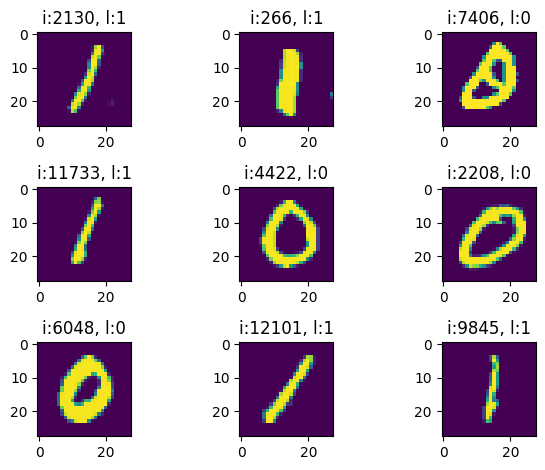

In [51]:
show_random_sample()

* How can we tell apart 0s and 1s?

### First Idea

In [54]:
def total_active_cells(image_data):
    """(-1,28,28) -> (-1) : counts total pixels with non-zero intensity"""
    return np.sum(image_data.clip(min=0,max=1), axis=(1,2))

total_active_cells_feature = total_active_cells(image_data)

#### Visualizing the feature

First, we can see its values for some images

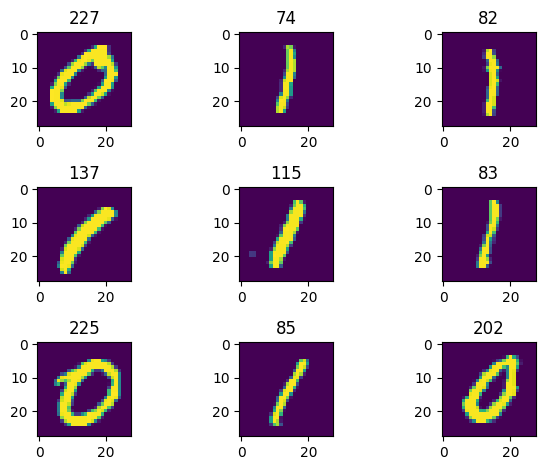

In [53]:
show_random_sample(titles=total_active_cells_feature)

We need a more "global" view of the feature

(array([  3.,  29.,  65., 177., 476., 698., 788., 733., 823., 703., 659.,
        487., 352., 269., 148.,  99.,  76.,  63.,  31.,  23.,  20.,   9.,
          4.,   2.,   1.,   1.,   0.,   1.,   1.,   1.]),
 array([ 34.        ,  39.86666667,  45.73333333,  51.6       ,
         57.46666667,  63.33333333,  69.2       ,  75.06666667,
         80.93333333,  86.8       ,  92.66666667,  98.53333333,
        104.4       , 110.26666667, 116.13333333, 122.        ,
        127.86666667, 133.73333333, 139.6       , 145.46666667,
        151.33333333, 157.2       , 163.06666667, 168.93333333,
        174.8       , 180.66666667, 186.53333333, 192.4       ,
        198.26666667, 204.13333333, 210.        ]),
 <BarContainer object of 30 artists>)

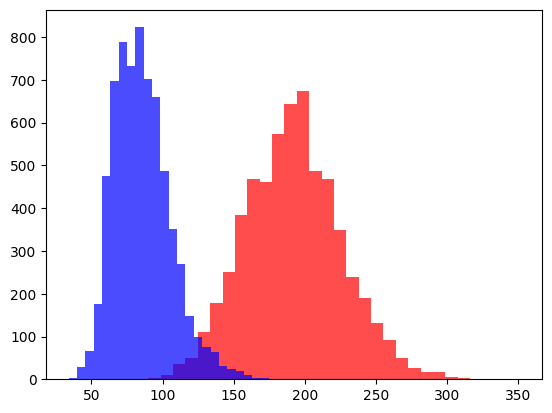

In [56]:
alpha=.7
bins=30
plt.hist(total_active_cells_feature[label_data == 0], bins=bins, alpha=alpha, color='red', label='0')
plt.hist(total_active_cells_feature[label_data == 1], bins=bins, alpha=alpha, color='blue', label='1')

#### First Attempt

In [58]:
# implement

## Optimized Implementations

In [60]:
import typing as T

In [61]:
def batch_accuracy(batch_predictions: np.ndarray, truth: np.ndarray) -> np.ndarray:
    """(m,n), (n) -> (m)"""
    return (batch_predictions == truth.reshape((1,-1))).mean(axis=1)

In [89]:
from dataclasses import dataclass

@dataclass
class GridSearchResult:
    optimal_parameter_index: int
    optimal_parameter: float
    best_accuracy: float
    search_history: np.ndarray


def grid_search_binary_classifier(
    kernel: np.ndarray,
    image_data: np.ndarray,
    label_data: np.ndarray,
    labels: T.Tuple[int, int],
    n = 128,
) -> GridSearchResult:
    """(28,28), (-1,28,28), (-1) -> best_parameter, best_accuracy, search_results"""
    features = (kernel.reshape((1, 28, 28)) * image_data.clip(min=0, max=1)).sum(axis=(1, 2))
    f0 = features[label_data == labels[0]]
    f1 = features[label_data == labels[1]]
    f0_max = f0.max()
    f1_min = f1.min()
    if f0_max < f1_min:
        optimal_parameter_index = 0
        optimal_parameter = (f0_max + f1_min) / 2
        best_accuracy = 1.0
        search_history = np.array([optimal_parameter, accuracy]).reshape((-1,2))
        return optimal_parameter, 
    else:
        parameters = np.linspace(f1_min, f0_max, n)
        predictions = np.where(features.reshape((1,-1)) < parameters.reshape((-1,1)), labels[0], labels[1])
        # rows are for parameters, columns are predictions for images
        assert predictions.shape == ((parameters.shape[0], image_data.shape[0]))
        accuracy = batch_accuracy(predictions, label_data)

        optimal_parameter_index = np.argmax(accuracy)
        optimal_parameter = parameters[optimal_parameter_index]
        best_accuracy = accuracy[optimal_parameter_index]
        search_history = np.hstack([parameters.reshape((-1,1)), accuracy.reshape((-1,1))])
    return GridSearchResult(
        optimal_parameter_index=optimal_parameter_index,
        optimal_parameter=optimal_parameter,
        best_accuracy=best_accuracy,
        search_history=search_history,
    )


In [90]:
def show_grid_search_result(grid_search_result: GridSearchResult):
    fig, ax = plt.subplots()
    history = grid_search_result.search_history
    ax.scatter(history[:,0], history[:,1], marker='s', s=1)
    ax.vlines(grid_search_result.optimal_parameter, history[:,1].min(), 1.0)
    ax.set_title(f'optimal_param:{grid_search_result.optimal_parameter:8.3f}, best_accuracy: {grid_search_result.best_accuracy:6.4f}')
    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'optimal_param: 131.412, best_accuracy: 0.9722'}>)

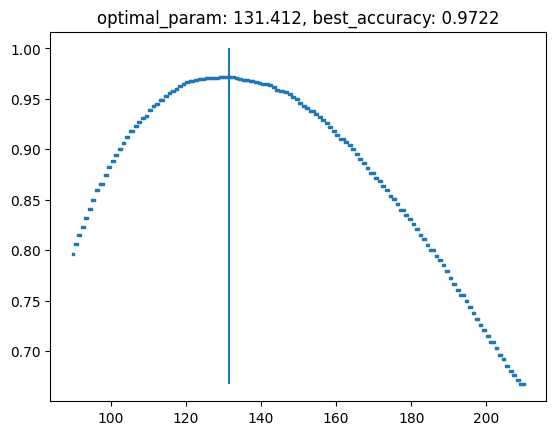

In [91]:
grid_search_result = grid_search_binary_classifier(np.ones((28,28)), image_data, label_data, labels=[1,0], n=256)
show_grid_search_result(grid_search_result)
# grid_search_result